# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku 
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


# Read Data

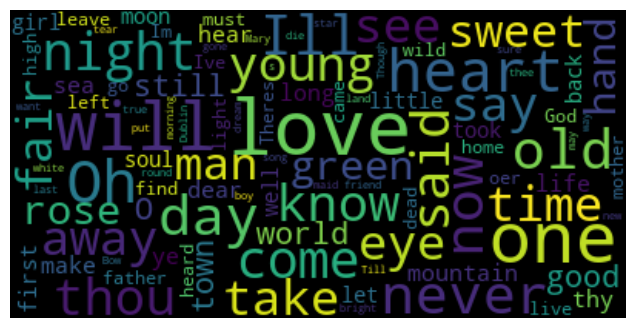

In [2]:
# Reading the text data file
data = open('datasets/english_poem.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()


# Make Corpus

In [3]:
# Generating the corpus by 
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


# Tokenize

In [4]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)


Total Words: 3807


# Vectorize

In [15]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	# print(token_list)
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]


In [16]:
label.shape

(16311,)

In [6]:
label = ku.to_categorical(label, num_classes=total_words+1)


In [12]:
input_sequences.shape

(16311, 16)

In [9]:
label.shape

(16311, 3808)

In [10]:
predictors.shape

(16311, 15)

In [11]:
total_words

3807

# Build Model

In [6]:
# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100, 
					input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
				kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           380800    
                                                                 
 bidirectional (Bidirection  (None, 15, 300)           301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 3807)              384507    
                                                                 
 dense_1 (Dense)             (None, 3808)              14500864  
                                                        

# Train

In [7]:
history = model.fit(predictors, label, epochs=150, verbose=1)

Epoch 1/150
510/510 [==============================] - 93s 172ms/step - loss: 6.9471 - accuracy: 0.0605
Epoch 2/150
510/510 [==============================] - 86s 169ms/step - loss: 6.4972 - accuracy: 0.0612
Epoch 3/150
510/510 [==============================] - 84s 165ms/step - loss: 6.3306 - accuracy: 0.0648
Epoch 4/150
510/510 [==============================] - 85s 167ms/step - loss: 6.2071 - accuracy: 0.0712
Epoch 5/150
510/510 [==============================] - 83s 162ms/step - loss: 6.1007 - accuracy: 0.0753
Epoch 6/150
510/510 [==============================] - 82s 161ms/step - loss: 5.9840 - accuracy: 0.0818
Epoch 7/150
510/510 [==============================] - 82s 162ms/step - loss: 5.8575 - accuracy: 0.0890
Epoch 8/150
510/510 [==============================] - 83s 162ms/step - loss: 5.7429 - accuracy: 0.0950
Epoch 9/150
510/510 [==============================] - 84s 164ms/step - loss: 5.6262 - accuracy: 0.1014
Epoch 10/150
510/510 [==============================] - 88s 173m

# Predict

In [17]:
model = load_model('english_lstm.h5')

In [20]:

seed_text = "the world seems so bright so good then go there then not  wid my free kerrigan stole be grieve and relations he said you so then it return a handsome rover one "
next_words = 20
ouptut_text = ""
 
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len-1,
      padding='pre')
    predicted = np.argmax(model.predict(token_list, 
                                        verbose=0), axis=-1)
    output_word = ""
     
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
             
    seed_text += " " + output_word
     
print(seed_text)

the world seems so bright so good then go there then not  wid my free kerrigan stole be grieve and relations he said you so then it return a handsome rover one  gay for the fire of spancil hill and sand in spancil brightly too late too late are they say true
